In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys


# Build a Variational Autoencoder (VAE) for a human face dataset

We will use a dataset containing images of people and train a variational autoencoder on it. 

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [2]:
path = 'lfw'

In [3]:
transform    = transforms.Compose([transforms.ToTensor()]) 
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True)


This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [4]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    print ("MPS device not found.")


torch.Size([250, 250, 3])


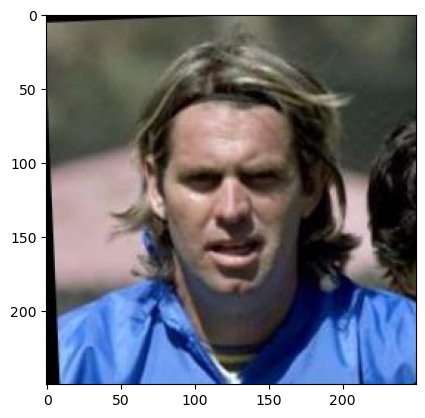

In [5]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

# Step 2
The basis for this project is that you can alter your implementation of AutoEncoders from the previous homework and add the necessary bits for a VAE.  Clearly state what is the difference between AutoEncoders and VAEs in terms of Applications, Architecture and Loss function. 

## Applications:

- AEs are mostly used for dimension reduction or feature learning. They excel in compressing input data and then reconstructing the input from this compressed representation.

- Because VAEs are generative models, they can generate new data that is comparable to the input data. They are frequently employed in tasks such as picture production, anomaly detection, and more advanced forms of feature learning.

## Architecture:

- An encoder compresses the input into a latent space representation, and a decoder reconstructs the input from the latent space in AEs.

- VAEs include encoders and decoders as well, but the encoder outputs parameters to a probability distribution, often a Gaussian distribution. The latent representation is then sampled from this distribution, introducing unpredictability into the model and allowing data production.

## Loss Function:

- AEs employ a loss function that typically assesses the reconstruction error between the input and its reconstruction, such as mean squared error.

- VAEs employ a loss function with two components: a reconstruction loss (similar to AEs) and a regularization term known as the Kullback-Leibler (KL) divergence. The KL divergence evaluates how far the learnt distribution in latent space deviates from a previous distribution, which is frequently set to be a standard Gaussian distribution. This term motivates the model to learn efficient and well-formed latent spaces, hence boosting its generative skills.

# Step 3

Update your pytorch autoencoder model class to create your VAE. Assume the encoder produces the mean and log variance of the latent space.  

**Create separate functions for the encoder and decoder.**

In [6]:
import torch
from torch import nn
from torch.nn import functional as F

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        # Encoder
        self.conv1 = nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)
        
        # Calculate the size of the flattened layer dynamically
        self._to_linear = None
        self._calculate_flat_size((3, 250, 250))  # This should be the size of your input images
        
        self.fc1 = nn.Linear(self._to_linear, 1024)
        self.fc21 = nn.Linear(1024, 20)
        self.fc22 = nn.Linear(1024, 20)
        
        # Decoder
        self.fc3 = nn.Linear(20, 1024)
        self.fc4 = nn.Linear(1024, 256*16*16)
        self.deconv1 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)
        self.deconv2 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.deconv3 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
        self.deconv4 = nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1)
    
    def _calculate_flat_size(self, shape):
        with torch.no_grad():
            x = torch.ones(1, *shape)
            x = self.conv1(x)
            x = self.conv2(x)
            x = self.conv3(x)
            x = self.conv4(x)
            self._to_linear = x.view(-1).shape[0]
            
    def encode(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = x.view(-1, self._to_linear)
        x = F.relu(self.fc1(x))
        return self.fc21(x), self.fc22(x)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        z = F.relu(self.fc3(z))
        z = F.relu(self.fc4(z))
        z = z.view(-1, 256, 16, 16) # Reshape for the transposed convolutional layers
        
        # Use transposed convolutions to upsample to the previous layer's spatial dimensions
        z = F.relu(self.deconv1(z))
        z = F.relu(self.deconv2(z))
        z = F.relu(self.deconv3(z))
        
        # The output should match the input image size, which is [32, 3, 250, 250]
        # Adjust the kernel size, stride, and padding to get the desired output size
        z = self.deconv4(z)  # No need for activation here, as it will be applied after resizing

        # Resize to the correct output size if necessary
        z = F.interpolate(z, size=(250, 250), mode='bilinear', align_corners=False)
        z = torch.sigmoid(z)  # Apply sigmoid to scale the pixel values to [0, 1]
        return z


    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar



## Importing Libraries:

The code starts by importing the necessary libraries, including PyTorch.

### VAE Class Definition:

The VAE class is defined, which is the main architecture for the Variational Autoencoder.

###  Encoder:

The encoder part of the VAE is defined first. This part takes an input image and maps it to a lower-dimensional latent space.
Convolutional layers (self.conv1, self.conv2, self.conv3, self.conv4) are used to extract features from the input image.
The _calculate_flat_size method is used to dynamically calculate the size of the flattened layer based on the input image size.
Fully connected layers (self.fc1, self.fc21, self.fc22) are used to map the extracted features to mean (mu) and log variance (logvar) vectors in the latent space.

### Reparameterization Trick:

The reparameterize method is defined to sample from the latent space using the mean (mu) and log variance (logvar) vectors. This is a key step in the VAE training process.

### Decoder:

The decoder part of the VAE is defined. It takes a point in the latent space and maps it back to the original input image space.
Fully connected layers (self.fc3, self.fc4) are used to map the latent space point to a higher-dimensional representation.
Transposed convolutional layers (self.deconv1, self.deconv2, self.deconv3) are used to upsample the representation to the original image size.
The final transposed convolutional layer (self.deconv4) generates the reconstructed image.

### Forward Method:

The forward method combines the encoder and decoder. It takes an input image x, encodes it to obtain mu and logvar, reparameterizes it, and decodes it to generate the reconstructed image.

### Sigmoid Activation:

A sigmoid activation function is applied to the output of the final convolutional layer in the decoder. This scales the pixel values of the reconstructed image to the range [0, 1].

### Interpolation:

After the final convolutional layer, the F.interpolate function is used to resize the output to the desired image size (in this case, (250, 250)) using bilinear interpolation. This ensures that the output matches the input image size.

## Step 4
Create an instance of the new class, pass an image to the model

*  print the shape of the output of the **encoder**. Explain how would you generate new samples in the latent space. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.
*  use the decoder to create new images. Print the shape of the output and verify that the forward pass is working correctly. 

In [7]:
# Create an instance of VAE class
model = VAE().to(device)

# Assuming the dataloader has been defined and is loaded with images of the correct dimensions
dataiter = iter(dataloader)
images, _ = next(dataiter)
images = images.to(device)

# Pass an image through the model
with torch.no_grad():
    model.eval()
    mu, logvar = model.encode(images[0].unsqueeze(0))  # Corrected this line
    print("Shape of the encoder's output (mu):", mu.shape)
    print("Shape of the encoder's output (logvar):", logvar.shape)

    # Generate new samples in the latent space and decode them to create new images
    samples = model.reparameterize(mu, logvar)
    print("Shape of the samples in the latent space:", samples.shape)
    generated_images = model.decode(samples)
    print("Shape of the decoder's output (generated images):", generated_images.shape)


Shape of the encoder's output (mu): torch.Size([1, 20])
Shape of the encoder's output (logvar): torch.Size([1, 20])
Shape of the samples in the latent space: torch.Size([1, 20])
Shape of the decoder's output (generated images): torch.Size([1, 3, 250, 250])


### Create an instance of the VAE class:

- You create an instance of the VAE class and move it to the specified device (assuming device is defined).

### Load and preprocess an image:

- Assuming you have a DataLoader (dataloader) loaded with images, you obtain a batch of images using iter(dataloader) and select the first image from the batch. You also move this image to the same device as the model.

### Pass the image through the model:

- You use the model.encode method to encode the input image. It returns the mean (mu) and log variance (logvar) vectors in the latent space.
- You print the shapes of these encoder outputs to inspect their dimensions.

### Generate new samples in the latent space:

- After obtaining mu and logvar, you use the model.reparameterize method to sample from the latent space based on these parameters. This is the reparameterization trick, which is essential for VAEs.
- You print the shape of the samples in the latent space.

### Decode the samples to generate new images:

- You use the model.decode method to decode the sampled points in the latent space. This generates new images.
- You print the shape of the decoder's output, which corresponds to the generated images.

##  Step 5
* Print the total number of parameters in the model
* Explain what loss should be used here. Describe in your own words the terms of the loss function and what goal each term of the loss function achieves. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.


* create an optimizer for training

In [8]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters.')


The model has 127,600,363 trainable parameters.


In [9]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')

    # Kullback-Leibler divergence
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

###  Counting Trainable Parameters:

The code uses a function named count_parameters(model) to count and print the total number of trainable parameters in the VAE model. This is an essential step to understand the complexity and size of the model.
The function iterates through all the model parameters and checks if they are marked as "requires_grad," which indicates that they are trainable.
The result is then printed to the console, giving you an idea of how many parameters the model contains.
Understanding the number of parameters is crucial for assessing the computational resources required for training and the model's capacity to learn from the data.

### Loss Function Explanation:

The loss function is a crucial component of the training process for a Variational Autoencoder (VAE). It guides the model to learn the desired behavior and helps in optimizing its parameters.
In the provided code, the loss function for the VAE consists of two main terms: the Binary Cross-Entropy (BCE) loss and the Kullback-Leibler Divergence (KLD) term.
a. Binary Cross-Entropy (BCE) Loss:

BCE is used to measure the dissimilarity between the reconstructed data and the original input data. It assesses how well the VAE can reconstruct the input data from the latent space representation.
In the context of VAEs, the BCE loss quantifies the difference between the generated data (recon_x) and the real input data (x).
The reduction='sum' argument means that BCE loss is computed by summing the losses over all elements in the batch.
The BCE loss term encourages the model to generate outputs that closely match the original inputs.
b. Kullback-Leibler Divergence (KLD) Term:

KLD is a regularization term that ensures the latent space of the VAE follows a specific probability distribution, often a standard Gaussian distribution (mean=0, variance=1).

KLD measures how different the distribution of the latent variables (mu and logvar) learned by the VAE is from the desired Gaussian distribution.

The formula for KLD is: -0.5 * âˆ‘(1 + logvar - mu^2 - exp(logvar))

The goal of the KLD term is to make the latent space more structured and encourage it to follow a Gaussian distribution.

This regularization term prevents the latent space from collapsing into a single point and promotes the generation of diverse samples during decoding.

The final loss function for the VAE is a combination of these two terms, where BCE encourages accurate data reconstruction, and KLD encourages a well-structured and diverse latent space.

In summary, the loss function guides the VAE during training by balancing reconstruction accuracy and regularization of the latent space, ultimately leading to the generation of meaningful and diverse data samples during decoding.

##  Step 6
Write a training loop and start training the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

In [10]:
epochs=10
# Training loop
# Training loop
for epoch in range(1, epochs + 1):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(dataloader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 10 == 0:  # Print every 10 batches
            print(f'Epoch: {epoch} [{batch_idx * len(data)}/{len(dataloader.dataset)} ({100. * batch_idx / len(dataloader):.0f}%)]\tLoss: {loss.item() / len(data):.6f}')
    
    average_loss = train_loss / len(dataloader.dataset)
    print(f'====> Epoch: {epoch} Average loss: {average_loss:.4f}')


# Sample and visualize images
with torch.no_grad():
    sample = torch.randn(64, 20).to(device)
    sample = model.decode(sample).cpu()
    # Visualize the generated images

Epoch: 1 [0/13237 (0%)]	Loss: 129014.867188
Epoch: 1 [320/13237 (2%)]	Loss: 128822.125000
Epoch: 1 [640/13237 (5%)]	Loss: 128350.812500
Epoch: 1 [960/13237 (7%)]	Loss: 127699.664062
Epoch: 1 [1280/13237 (10%)]	Loss: 127450.031250
Epoch: 1 [1600/13237 (12%)]	Loss: 123323.296875
Epoch: 1 [1920/13237 (14%)]	Loss: 118908.468750
Epoch: 1 [2240/13237 (17%)]	Loss: 115751.210938
Epoch: 1 [2560/13237 (19%)]	Loss: 119837.546875
Epoch: 1 [2880/13237 (22%)]	Loss: 117010.046875
Epoch: 1 [3200/13237 (24%)]	Loss: 111426.617188
Epoch: 1 [3520/13237 (27%)]	Loss: 116428.476562
Epoch: 1 [3840/13237 (29%)]	Loss: 116662.062500
Epoch: 1 [4160/13237 (31%)]	Loss: 113458.273438
Epoch: 1 [4480/13237 (34%)]	Loss: 113107.171875
Epoch: 1 [4800/13237 (36%)]	Loss: 110980.507812
Epoch: 1 [5120/13237 (39%)]	Loss: 109735.585938
Epoch: 1 [5440/13237 (41%)]	Loss: 112454.093750
Epoch: 1 [5760/13237 (43%)]	Loss: 111985.882812
Epoch: 1 [6080/13237 (46%)]	Loss: 112944.445312
Epoch: 1 [6400/13237 (48%)]	Loss: 111056.445312
Ep

Epoch: 5 [640/13237 (5%)]	Loss: 97866.726562
Epoch: 5 [960/13237 (7%)]	Loss: 99383.531250
Epoch: 5 [1280/13237 (10%)]	Loss: 99227.476562
Epoch: 5 [1600/13237 (12%)]	Loss: 96163.726562
Epoch: 5 [1920/13237 (14%)]	Loss: 96877.804688
Epoch: 5 [2240/13237 (17%)]	Loss: 98620.234375
Epoch: 5 [2560/13237 (19%)]	Loss: 99094.289062
Epoch: 5 [2880/13237 (22%)]	Loss: 96561.273438
Epoch: 5 [3200/13237 (24%)]	Loss: 99033.750000
Epoch: 5 [3520/13237 (27%)]	Loss: 95579.507812
Epoch: 5 [3840/13237 (29%)]	Loss: 93779.046875
Epoch: 5 [4160/13237 (31%)]	Loss: 96082.226562
Epoch: 5 [4480/13237 (34%)]	Loss: 95552.007812
Epoch: 5 [4800/13237 (36%)]	Loss: 98957.914062
Epoch: 5 [5120/13237 (39%)]	Loss: 93641.234375
Epoch: 5 [5440/13237 (41%)]	Loss: 94931.273438
Epoch: 5 [5760/13237 (43%)]	Loss: 94521.421875
Epoch: 5 [6080/13237 (46%)]	Loss: 95644.460938
Epoch: 5 [6400/13237 (48%)]	Loss: 97503.695312
Epoch: 5 [6720/13237 (51%)]	Loss: 95837.398438
Epoch: 5 [7040/13237 (53%)]	Loss: 96394.671875
Epoch: 5 [7360/13

Epoch: 9 [1600/13237 (12%)]	Loss: 96964.710938
Epoch: 9 [1920/13237 (14%)]	Loss: 98539.898438
Epoch: 9 [2240/13237 (17%)]	Loss: 95097.117188
Epoch: 9 [2560/13237 (19%)]	Loss: 97070.078125
Epoch: 9 [2880/13237 (22%)]	Loss: 97247.976562
Epoch: 9 [3200/13237 (24%)]	Loss: 99220.039062
Epoch: 9 [3520/13237 (27%)]	Loss: 96839.781250
Epoch: 9 [3840/13237 (29%)]	Loss: 97983.101562
Epoch: 9 [4160/13237 (31%)]	Loss: 99867.140625
Epoch: 9 [4480/13237 (34%)]	Loss: 95385.562500
Epoch: 9 [4800/13237 (36%)]	Loss: 95851.046875
Epoch: 9 [5120/13237 (39%)]	Loss: 94933.437500
Epoch: 9 [5440/13237 (41%)]	Loss: 97632.429688
Epoch: 9 [5760/13237 (43%)]	Loss: 100269.484375
Epoch: 9 [6080/13237 (46%)]	Loss: 96578.460938
Epoch: 9 [6400/13237 (48%)]	Loss: 95954.960938
Epoch: 9 [6720/13237 (51%)]	Loss: 98611.375000
Epoch: 9 [7040/13237 (53%)]	Loss: 93598.859375
Epoch: 9 [7360/13237 (56%)]	Loss: 99373.054688
Epoch: 9 [7680/13237 (58%)]	Loss: 99166.570312
Epoch: 9 [8000/13237 (60%)]	Loss: 97728.320312
Epoch: 9 [83

In the provided code, a training loop is executed for a total of 10 epochs, where the Variational Autoencoder (VAE) model is trained on the given dataset. The loop iterates through batches of data, computes the reconstruction loss using the defined loss function, and updates the model's parameters using the optimizer. Training progress is printed, including the current epoch and batch loss.

After training, the code generates 64 random samples in the latent space, decodes them using the trained VAE model, and visualizes the generated images. These generated images demonstrate the VAE's ability to create new data samples based on its learned latent representations.

The training loop aims to minimize the reconstruction loss and regularize the latent space, while the subsequent sampling and visualization showcase the generative capabilities of the trained VAE.

##  Step 7

Take a random image from the dataset and plot it together with new samples generated.

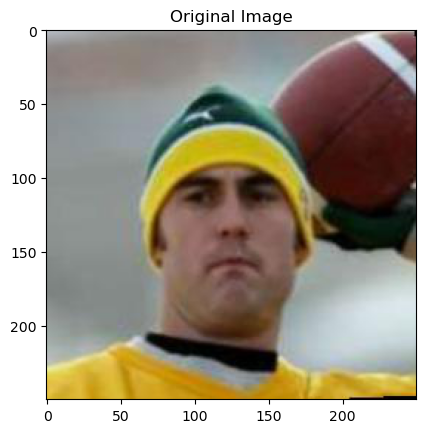

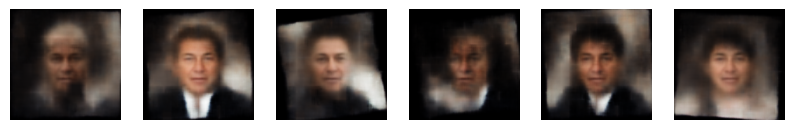

In [11]:
import matplotlib.pyplot as plt

# After training
model.eval()

# Take a random image from the dataset
with torch.no_grad():
    for i, (data, _) in enumerate(dataloader):
        if i == random.randint(0, len(dataloader)):
            original_image = data[0].to(device)
            plt.imshow(original_image.cpu().permute(1, 2, 0))
            plt.title("Original Image")
            plt.show()
            break

# Generate new samples and plot them
with torch.no_grad():
    sample = torch.randn(64, 20).to(device)
    generated_images = model.decode(sample).cpu()
    
    # Plot the generated images
    fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(10, 2))
    for ax, img in zip(axes.flat, generated_images):
        ax.imshow(img.permute(1, 2, 0))
        ax.axis('off')
    plt.show()
